In [1]:
import pandas as pd
import numpy as np
import os
import sys
!pip -qq install psutil
import psutil
from time import time, sleep
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import resource
from glob import glob
from IPython.display import clear_output
from NSGPy.NumPy import LLS

## Data preperation

In [2]:
main_path = '~/Nonstat-exps/gp_extra/'
df = pd.read_csv(main_path+'data/beijing_AQI.csv').rename(columns={'PM25_Concentration':'PM25','longitude':'long','latitude':'lat'})
df = df.set_index('time').sort_index()
print('unique timestamps are',len(df.index.unique()))
useful_ts = []
for ts in df.index.unique():
  if(len(df.loc[ts])==36):
    useful_ts.append(ts)
df = df.loc[useful_ts]
df['PM25'] = df['PM25'].astype(float)
print('unique timestamps after removing missing entry time-stamps are',len(useful_ts))
df.columns

n_ts = len(useful_ts)
K = 3 #  Number of folds
n_val = 6 # Number of validation stations

splitter = KFold(K, shuffle=True, random_state=0)
stations = np.sort(df['station_id'].unique())
folds={i:{'train':None,'val':None,'test':None} for i in range(K)}
for i, (train_val, test) in enumerate(splitter.split(stations)):
    folds[i]['train'] = stations[train_val[:-n_val]]
    folds[i]['val'] = stations[train_val[-n_val:]]
    folds[i]['test'] = stations[test]
    
###########################
# Data preperation
###########################
data = {i:{'train_Xy':None,'val_Xy':None,'test_Xy':None} for i in range(K)}
for fold in range(K):
    for part in ['train','val','test']:
        data[fold][part+'_Xy'] = (df[df.station_id.isin(folds[fold][part])][['long', 'lat']], 
                                  df[df.station_id.isin(folds[fold][part])][['PM25']])

unique timestamps are 7460
unique timestamps after removing missing entry time-stamps are 2132


## K fold GP-LLS - matern

In [3]:
path = 'results/raw_gp_lls_self/'
kernel = 'matern'

### Training

In [4]:
# init = time()
# # while len(glob(path+'/*')) != len(useful_ts):
# jobs = []
# for fold in range(K):
#     for ts in range(n_ts):
#         jobs.append('python scripts/process_gp_lls_self.py {0} {1} {2}'.format(ts, fold, kernel))

# print('starting',len(jobs),'jobs on',psutil.cpu_count(),'CPUs')
# sleep(5)
# os.system(' | '.join(jobs))
# n_splits = len(jobs)//64+1
# for b_id, batch in enumerate(np.array_split(jobs, n_splits)):
#     print('start',b_id+1,'of',n_splits)
#     print('length of batch=',len(batch))
#     os.system(' | '.join(batch))
#     clear_output(wait=True)
#     print('end',b_id+1,'of',n_splits)
# #     for j_id,job in enumerate(jobs):
# #         os.system(job)
# #         clear_output(wait=True)
# #         print(j_id)
# print('round complete')
# print((time()-init)/60, 'all fold complete')

### RMSE calculation

In [5]:
path = 'results/raw_gp_lls_self/'+kernel+'/'
preds = []
tests = []
success = []
for fold in folds:
    hyp = []
    fold_rmse = []
    tmp_preds_y = []
    tmp_models = []
    tmp_tests_y = []
    tmp_tests_x = []
    tmp_train_Xy = []
    for ts_n, ts in enumerate(df.index.unique()[:n_ts]):
        try:
            tmp = pd.read_pickle(path+'ts_'+str(ts)+'_fold_'+str(fold))
            hyp.append(tmp['best_hyperpara']['N'])
            preds.append(tmp['pred_y'].squeeze())
            tests.append(tmp['test_y'].squeeze())
            tmp_models.append(tmp['best_model'])
            tmp_train_Xy.append(tmp['train_Xy'])
            tmp_tests_x.append(tmp['test_Xy'][0].squeeze())
            tmp_preds_y.append(tmp['pred_y'].squeeze())
            tmp_tests_y.append(tmp['test_y'].squeeze())
            success.append(path+'ts_'+str(ts)+'_fold_'+str(fold))
            fold_rmse.append(mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False))
        except:
            pass
    print("Fold",fold,'rmse',mean_squared_error(np.array(tmp_tests_y).flatten(), np.array(tmp_preds_y).flatten(), squared=False))
print("Overall RMSE", mean_squared_error(np.array(tests).flatten(), np.array(preds).flatten(), squared=False))
pd.Series(hyp).value_counts()

Fold 0 rmse 49.3133648956928
Fold 1 rmse 35.129954685431905
Fold 2 rmse 39.82663629113066
Overall RMSE 41.87410459564041


3    411
4    404
9    279
8    277
5    266
7    245
6    228
dtype: int64

In [17]:
N = 1
tmp_models[N].params, fold_rmse[N], hyp[N]

({'likelihood (mll)': 50.51767385675005,
  'GP_variance (sigma_f)': array([138.66462219]),
  'GP_noise_level (sigma_n)': array([139.28089971]),
  'L_GP_variance (sigma_f_bar)': array([11.99465741, 17.66401384]),
  'L_GP_lengthscale (sigma_l_bar)': array([27.25034855, 83.53960916]),
  'L_GP_noise_level (sigma_n_bar)': array([4.40482939e+01, 1.00000000e-05]),
  'N_lengthscales (l_bar)': array([[  7.81103935,   5.66363731],
         [  4.25812628,   1.79656926],
         [ 11.65751537,   0.59547428],
         [  0.78134816,   3.50460352],
         [139.4181094 ,   2.47953721],
         [  4.77255972,   6.66210073],
         [  4.51255554,  10.99269891],
         [ 13.81579061,   6.93025578],
         [ 69.15414093,   2.37170552]])},
 21.078405135179644,
 9)

In [14]:
N = 0
fold = 2
ts = df.index.unique()[N]
scaler = StandardScaler()
model = LLS(2, N_l_bar=7, kernel='matern', seed=0, bounds=(10**-3, 10**3))
model.fit(scaler.fit_transform(data[fold]['train_Xy'][0].loc[ts].values), tmp_train_Xy[N][1])
model.params,\
mean_squared_error(data[fold]['test_Xy'][1].loc[ts].values, 
                   model.predict(scaler.transform(data[fold]['test_Xy'][0].loc[ts].values), False), squared=False)

({'likelihood (mll)': 15.75626370935802,
  'GP_variance (sigma_f)': array([146.88051346]),
  'GP_noise_level (sigma_n)': array([245.88757104]),
  'L_GP_variance (sigma_f_bar)': array([0.02066977, 0.01676469]),
  'L_GP_lengthscale (sigma_l_bar)': array([1000.        ,   19.86398661]),
  'L_GP_noise_level (sigma_n_bar)': array([0.001, 0.001]),
  'N_lengthscales (l_bar)': array([[ 701.24531815,  674.70323598],
         [  87.73531007,  429.39876257],
         [1000.        ,   41.27624574],
         [ 756.09399227,  726.79182812],
         [  64.82892485,  682.0001832 ],
         [  90.03349818,  257.89930659],
         [  22.26044694,  379.00149776]])},
 58.5470158787912)

In [6]:
!python scripts/process_gp_lls_self.py 0 1 matern

13.958859583532801 6


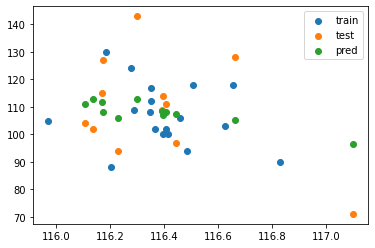

In [151]:
N = 0
dim = 0
plt.plot()
plt.scatter(tmp_train_Xy[N][0][:,dim], tmp_train_Xy[N][1],label='train')
plt.scatter(tmp_tests_x[N][:,dim], tmp_tests_y[N],label='test')
plt.scatter(tmp_tests_x[N][:,dim], tmp_preds_y[N],label='pred')
plt.legend();

In [ ]:
from NSGPy.NumPy import LLS
N = 9
dim = 1
plt.plot()
plt.scatter(tmp_train_Xy[N][0][:,dim], tmp_train_Xy[N][1],label='train')
plt.scatter(tmp_tests_x[N][:,dim], tmp_tests_y[N],label='test')
plt.scatter(tmp_tests_x[N][:,dim], tmp_preds_y[N],label='pred')
plt.legend();

In [38]:
pd.to_pickle(success, 'results/sync.pickle')

## K fold GP-LLS - rbf

In [128]:
path = 'results/raw_gp_lls_self/'
kernel = 'rbf'

### Training

In [ ]:
init = time()
# while len(glob(path+'/*')) != len(useful_ts):
jobs = []
for fold in range(K):
    for ts in range(n_ts):
        jobs.append('python scripts/process_gp_lls_self.py {0} {1} {2}'.format(ts, fold, kernel))

print('starting',len(jobs),'jobs on',psutil.cpu_count(),'CPUs')
sleep(5)
os.system(' | '.join(jobs))
n_splits = len(jobs)//64+1
for b_id, batch in enumerate(np.array_split(jobs, n_splits)):
    print('start',b_id+1,'of',n_splits)
    print('length of batch=',len(batch))
    os.system(' | '.join(batch))
    clear_output(wait=True)
    print('end',b_id+1,'of',n_splits)
#     for j_id,job in enumerate(jobs):
#         os.system(job)
#         clear_output(wait=True)
#         print(j_id)
print('round complete')
print((time()-init)/60, 'all fold complete')

starting 6396 jobs on 32 CPUs
start 1 of 100
length of batch= 64


### RMSE calculation

In [44]:
preds = []
tests = []
success = []
hyp = []
for fold in folds:
    fold_rmse = []
    tmp_preds_y = []
    tmp_models = []
    tmp_tests_y = []
    tmp_tests_x = []
    tmp_train_Xy = []
    for ts_n, ts in enumerate(df.index.unique()[:n_ts]):
        try:
            tmp = pd.read_pickle(path+'ts_'+str(ts)+'_fold_'+str(fold))
            hyp.append(tmp['best_hyperpara']['N'])
            preds.append(tmp['pred_y'].squeeze())
            tests.append(tmp['test_y'].squeeze())
            tmp_models.append(tmp['best_model'])
            tmp_train_Xy.append(tmp['train_Xy'])
            tmp_tests_x.append(tmp['test_Xy'][0].squeeze())
            tmp_preds_y.append(tmp['pred_y'].squeeze())
            tmp_tests_y.append(tmp['test_y'].squeeze())
            success.append(path+'ts_'+str(ts)+'_fold_'+str(fold))
            fold_rmse.append(mean_squared_error(tmp_tests_y[-1], tmp_preds_y[-1], squared=False))
        except:
            pass
    print("Fold",fold,'rmse',mean_squared_error(np.array(tmp_tests_y).flatten(), np.array(tmp_preds_y).flatten(), squared=False))
print("Overall RMSE", mean_squared_error(np.array(tests).flatten(), np.array(preds).flatten(), squared=False))
pd.Series(hyp).value_counts()

Fold 0 rmse 57.2379370162454
Fold 1 rmse 40.833994011152804
Fold 2 rmse 47.32437235549537
Overall RMSE 48.89817816510411


3    1206
4    1016
6     812
5     775
8     771
9     729
7     726
dtype: int64

In [45]:
fold_rmse[:10]

[15.652216040646225,
 30.936255326235997,
 17.1450568166559,
 21.641936943583264,
 21.937975495666148,
 23.783997178068958,
 53.35454019691483,
 19.527267920026823,
 25.165968822210676,
 47.11031197570313]

In [46]:
import matplotlib.pyplot as plt

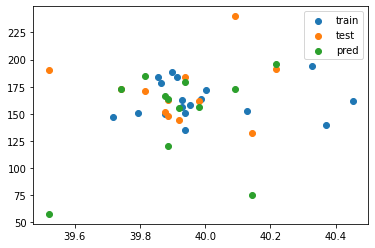

In [48]:
N = 9
dim = 1
plt.plot()
plt.scatter(tmp_train_Xy[N][0][:,dim], tmp_train_Xy[N][1],label='train')
plt.scatter(tmp_tests_x[N][:,dim], tmp_tests_y[N],label='test')
plt.scatter(tmp_tests_x[N][:,dim], tmp_preds_y[N],label='pred')
plt.legend();

In [ ]:
from NSGPy.NumPy import LLS
N = 9
dim = 1
plt.plot()
plt.scatter(tmp_train_Xy[N][0][:,dim], tmp_train_Xy[N][1],label='train')
plt.scatter(tmp_tests_x[N][:,dim], tmp_tests_y[N],label='test')
plt.scatter(tmp_tests_x[N][:,dim], tmp_preds_y[N],label='pred')
plt.legend();

In [38]:
pd.to_pickle(success, 'results/sync.pickle')

## K fold GP-LLS-matern-gp-extra

In [29]:
path = 'results/raw_gp_lls_matern_gp_extras/'
kern_name = 'matern'

In [8]:
from scipy.optimize import differential_evolution
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import ConstantKernel as C, Matern
from sklearn.metrics import mean_squared_error
from gp_extras.kernels import LocalLengthScalesKernel

def de_optimizer(obj_func, initial_theta, bounds):
    res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                 bounds, maxiter=20, disp=False, polish=False)
    return res.x, obj_func(res.x, eval_gradient=False)

### Training

In [9]:
jobs = []
for fold in range(K):
    for ts in range(n_ts):
        jobs.append('python scripts/process_gp_lls_gp_extras.py {0} {1} {2}'.format(ts, fold, kern_name))

print('starting',len(jobs),'jobs on',psutil.cpu_count(),'CPUs')
init = time()
maxa = 0
while len(glob(path+'/*')) != len(jobs):
    if maxa>10:
        break
    os.system(' | '.join(jobs))
#     for b_id, batch in enumerate(np.array_split(jobs, 4)):
#         os.system(' | '.join(batch))
#         clear_output(wait=True)
#         print(b_id)
#     for j_id,job in enumerate(jobs):
#         os.system(job)
#         clear_output(wait=True)
#         print(j_id)
    print('round complete')
    maxa+=1
print((time()-init)/60, 'all fold complete')

starting 96 jobs on 32 CPUs
round complete
3.5594407081604005 all fold complete


### RMSE calculation

In [10]:
preds = []
tests = []
hyp = []
for fold in folds:
    tmp_preds = []
    tmp_tests = []
    for ts_n, ts in enumerate(df.index.unique()[:n_ts]):
        tmp = pd.read_pickle(path+'ts_'+str(ts)+'_fold_'+str(fold))
        hyp.append(tmp['best_hyperpara']['N'])
        preds.append(tmp['pred_y'].squeeze())
        tests.append(tmp['test_y'].squeeze())
        tmp_preds.append(tmp['pred_y'].squeeze())
        tmp_tests.append(tmp['test_y'].squeeze())
    print("Fold",fold,'rmse',mean_squared_error(np.array(tmp_tests).flatten(), np.array(tmp_preds).flatten(), squared=False))
print("Overall RMSE", mean_squared_error(np.array(tests).flatten(), np.array(preds).flatten(), squared=False))
pd.Series(hyp).value_counts()

Fold 0 rmse 33.51401046314828
Fold 1 rmse 26.88769202915281
Fold 2 rmse 29.489337206990676
Fold 3 rmse 41.70269088245913
Overall RMSE 33.37241494005238


4    25
3    24
5    18
1    16
2    13
dtype: int64

## K fold GP-LLS-rbf-gp-extra

In [11]:
path = 'results/raw_gp_lls_rbf_gp_extras/'
kern_name = 'rbf'

In [12]:
from scipy.optimize import differential_evolution
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import ConstantKernel as C, Matern
from sklearn.metrics import mean_squared_error
from gp_extras.kernels import LocalLengthScalesKernel

def de_optimizer(obj_func, initial_theta, bounds):
    res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                 bounds, maxiter=20, disp=False, polish=False)
    return res.x, obj_func(res.x, eval_gradient=False)

### Training

In [13]:
jobs = []
for fold in range(K):
    for ts in range(n_ts):
        jobs.append('python scripts/process_gp_lls_gp_extras.py {0} {1} {2}'.format(ts, fold, kern_name))

print('starting',len(jobs),'jobs on',psutil.cpu_count(),'CPUs')
init = time()
maxa = 0
while len(glob(path+'/*')) != len(jobs):
    if maxa>10:
        break
    os.system(' | '.join(jobs))
#     for b_id, batch in enumerate(np.array_split(jobs, 4)):
#         os.system(' | '.join(batch))
#         clear_output(wait=True)
#         print(b_id)
#     for j_id,job in enumerate(jobs):
#         os.system(job)
#         clear_output(wait=True)
#         print(j_id)
    print('round complete')
    maxa+=1
print((time()-init)/60, 'all fold complete')

starting 96 jobs on 32 CPUs
round complete
5.006258841355642 all fold complete


### RMSE calculation

In [14]:
preds = []
tests = []
hyp = []
for fold in folds:
    tmp_preds = []
    tmp_tests = []
    for ts_n, ts in enumerate(df.index.unique()[:n_ts]):
        tmp = pd.read_pickle(path+'ts_'+str(ts)+'_fold_'+str(fold))
        hyp.append(tmp['best_hyperpara']['N'])
        preds.append(tmp['pred_y'].squeeze())
        tests.append(tmp['test_y'].squeeze())
        tmp_preds.append(tmp['pred_y'].squeeze())
        tmp_tests.append(tmp['test_y'].squeeze())
    print("Fold",fold,'rmse',mean_squared_error(np.array(tmp_tests).flatten(), np.array(tmp_preds).flatten(), squared=False))
print("Overall RMSE", mean_squared_error(np.array(tests).flatten(), np.array(preds).flatten(), squared=False))
pd.Series(hyp).value_counts()

Fold 0 rmse 50.90439913476052
Fold 1 rmse 39.52342210554558
Fold 2 rmse 50.13993464893882
Fold 3 rmse 53.810876381022204
Overall RMSE 48.89525081666328


3    33
2    19
5    16
4    14
1    14
dtype: int64

## Appendix

In [15]:
a=np.array([[1,2,3],[3,4,5]]).T
b=np.array([[4,5,6],[7,8,9]]).T
a.shape, a, b, b.shape

((3, 2),
 array([[1, 3],
        [2, 4],
        [3, 5]]),
 array([[4, 7],
        [5, 8],
        [6, 9]]),
 (3, 2))

In [16]:
GaussianProcessRegressor()

GaussianProcessRegressor()

In [17]:
tgp = np.array([1,2]).reshape(1,2)
sm = (a[:,np.newaxis,:]-b[np.newaxis,:,:]).reshape(-1,2)**2
act = np.sum(tgp*sm, axis=1)
tgp, sm, np.sum(tgp*sm, axis=1)

(array([[1, 2]]),
 array([[ 9, 16],
        [16, 25],
        [25, 36],
        [ 4,  9],
        [ 9, 16],
        [16, 25],
        [ 1,  4],
        [ 4,  9],
        [ 9, 16]]),
 array([41, 66, 97, 22, 41, 66,  9, 22, 41]))